# Exploratory data analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from pandas.plotting import scatter_matrix
import geopandas as gpd
import contextily as ctx

# Import from local library
from helsinkihouse.config import cleaned_data_path

%matplotlib inline
%load_ext autoreload
%autoreload 2  # reload modules before executing user code

In [2]:
housing = pd.read_excel(cleaned_data_path, index_col=0)
housing.head()

Link  \
0  https://www.etuovi.com/kohde/21189890?haku=M16...   
1  https://www.etuovi.com/kohde/7971959?haku=M160...   
2  https://www.etuovi.com/kohde/21772126?haku=M16...   
3  https://www.etuovi.com/kohde/1287367?haku=M160...   
4  https://www.etuovi.com/kohde/20553097?haku=M16...   

                                      Address   Price  Size  Year  House_type  \
0         Rosendalinrinki 3, Tammisto, Vantaa  227000  49.5  2009  Kerrostalo   
1         Kanttiinitie 6 B4, Painiitty, Espoo  385900  92.0  2022    Rivitalo   
2         Konalantie 4, Pitäjänmäki, Helsinki  205000  66.0  1963  Kerrostalo   
3  Ripusuontie 64 A 2, Länsi-Pakila, Helsinki  545000  92.0  2020    Rivitalo   
4        Kievarinraitti 2, Viherlaakso, Espoo  149000  56.0  1980  Kerrostalo   

                                         Description  Total_rooms   Latitude  \
0                                        2h + kt + s          2.0  60.268798   
1                                        4h + kt + s          4.0  60.237447   
2                                             3h + k          3.0  60.225724   
3   3-4h, k, kph / 2wc, khh, sauna, vh 92 m2 + lä...          3.0  60.247235   
4           2h + k + kph + wc (yht.järj.muk. 2h + k)          2.0  60.229167   

   Longitude  
0  24.968812  
1  24.834287  
2  24.853692  
3  24.945488  
4  24.742285

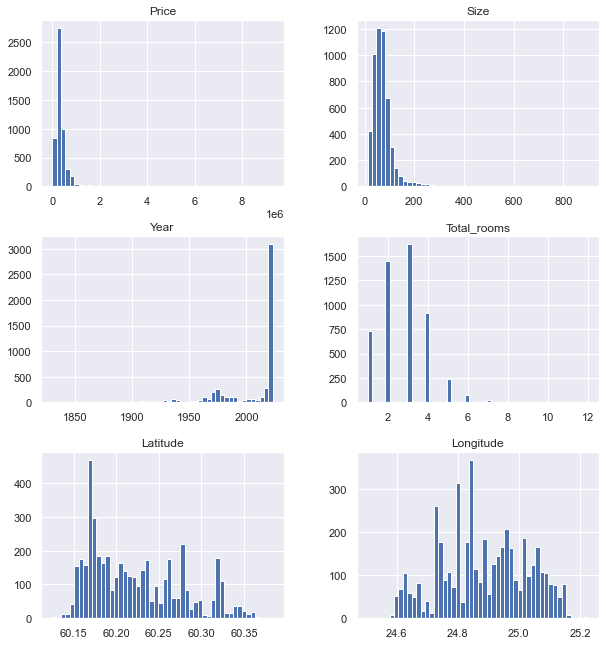

In [3]:
housing.hist(bins=50, figsize=(10, 11));

As we can see, most distributions except for Latiude and Longitude are skewed:
- _Price_ mostly contains values lower than 1 million euros with some extremely large values (e.g. 9.3 milliion €)
- _Size_ is also largely skeweed towards the lower end with most of the housing smaller than 200 squared meters.
- _Year_ is surprisingly (for me) skewed towards buildings from the current and past year.
- _Total_rooms_ is mostly between 2 and 3 rooms per house.
_Latitude_ and _Longitude_ are not very skewed, but we can see more on this in the following sections.

Based on the histogram for the price, I am curious about the presence of some very rara extreme high prices.

In [6]:
housing[housing.Price>3e6]

Link  ...  Longitude
76    https://www.etuovi.com/kohde/7964542?haku=M160...  ...  24.863660
435   https://www.etuovi.com/kohde/7970077?haku=M160...  ...  24.864015
510   https://www.etuovi.com/kohde/20362550?haku=M16...  ...        NaN
633   https://www.etuovi.com/kohde/7968394?haku=M160...  ...  24.866627
1157  https://www.etuovi.com/kohde/21104110?haku=M16...  ...  25.015084
2220  https://www.etuovi.com/kohde/7969579?haku=M160...  ...  24.789785
2408  https://www.etuovi.com/kohde/20917802?haku=M16...  ...  25.014137
3967  https://www.etuovi.com/kohde/n86779?haku=M1606...  ...  25.048773
4246  https://www.etuovi.com/kohde/2228665?haku=M160...  ...  24.858285
4253  https://www.etuovi.com/kohde/20027837?haku=M16...  ...        NaN
4368  https://www.etuovi.com/kohde/7947232?haku=M160...  ...  24.945162
4389  https://www.etuovi.com/kohde/20041445?haku=M16...  ...  24.942920
4541  https://www.etuovi.com/kohde/681330?haku=M1606...  ...  24.859260
5195  https://www.etuovi.com/kohde/9919816?haku=M160...  ...  25.005714

[14 rows x 10 columns]

In [7]:
housing[housing.Price==9300000].Link

633    https://www.etuovi.com/kohde/7968394?haku=M160...
Name: Link, dtype: object

## Basic statistics
It is interesting to look at some basic statistics to get an idea of the range of the values for the different attributes.

In [8]:
housing.describe()

Price         Size  ...     Latitude    Longitude
count  5.228000e+03  5228.000000  ...  4584.000000  4584.000000
mean   3.737330e+05    72.430260  ...    60.221863    24.885070
std    3.529972e+05    45.187783  ...     0.054915     0.141540
min    0.000000e+00    12.000000  ...    60.124636    24.505078
25%    2.225650e+05    46.000000  ...    60.173362    24.783111
50%    2.987800e+05    65.000000  ...    60.210752    24.880124
75%    4.098000e+05    85.000000  ...    60.261167    24.997378
max    9.300000e+06   900.000000  ...    60.383783    25.226951

[8 rows x 6 columns]

As is to be expected, the standard deviation is largest for the price as it has the largest range of values. The average appartment is 72 $m^2$, has 3 rooms and costs about 373000 €. Let's look at the median values.

In [9]:
housing.median()

Price          298780.000000
Size               65.000000
Year             2021.000000
Total_rooms         3.000000
Latitude           60.210752
Longitude          24.880124
dtype: float64

The median cost is lower than the mean one as the mean is more susceptible to outliers as the ones in the higher range. 

In [20]:
housing[housing.Price==0].Link  # there seems to be an error in one of the ads as the price is set to 0 €

588    https://www.etuovi.com/kohde/q46363?haku=M1606...
Name: Link, dtype: object

## Visualizing geographical data
Let's make the most out of the location to see how homogeneous is the spread of our data.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


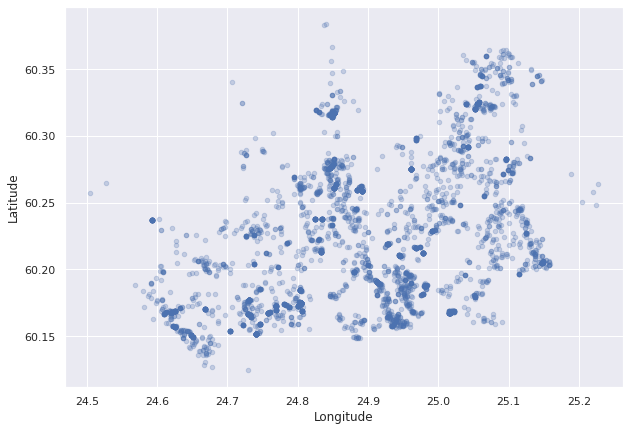

In [10]:
housing.plot(kind="scatter", x="Longitude", y="Latitude", alpha=0.25, figsize=(10,7));

Let's add some more detail to the graph by representing the price of the houses in the color palette.

No handles with labels found to put in legend.


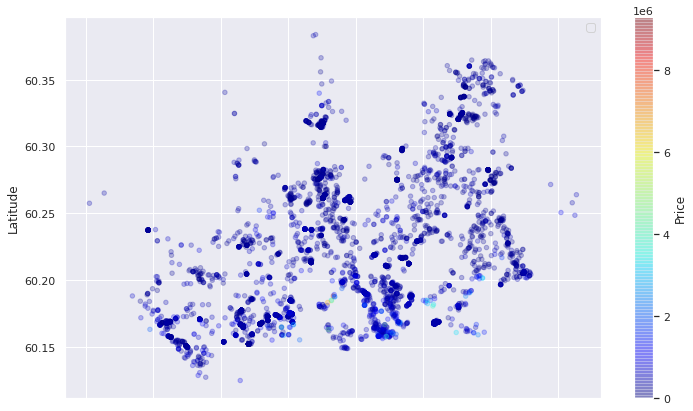

In [11]:
housing.plot(kind="scatter", x="Longitude", y="Latitude", alpha=0.25, 
             figsize=(12,7), c="Price", cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()

Since the larger values are very scarce and extremely large, the differences in colour between most of the housing is not easy to spot.  Let's look at the lower half of the prices to see better how the price is distributed

No handles with labels found to put in legend.


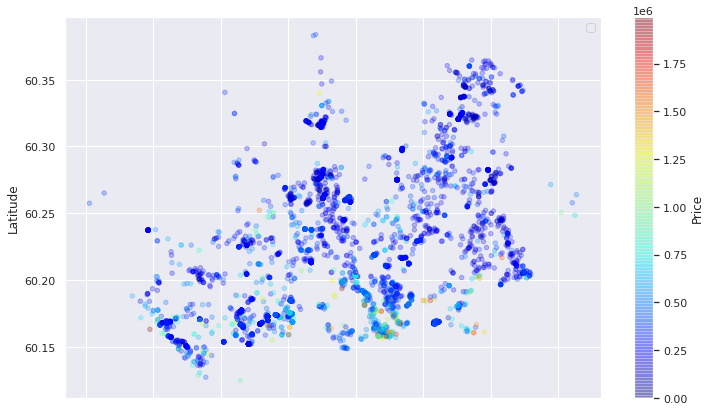

In [21]:
housing[housing.Price<2e6].plot(kind="scatter", x="Longitude", y="Latitude", alpha=0.25, 
             figsize=(12,7), c="Price", cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()

By looking only at prices worth less than 2M€ we are able to see more clustering of higher prices in certain areas (especially closer to the shore).

In [24]:
housing.Latitude.mean(), housing.Longitude.mean()

(60.22186284237546, 24.885069945259353)

In [50]:
from bokeh.io import output_file, output_notebook, show
from bokeh.models import (
  GMapPlot, GMapOptions, ColumnDataSource, Circle, LogColorMapper, BasicTicker, ColorBar,
    Range1d, PanTool, WheelZoomTool, BoxSelectTool
)
from bokeh.models.mappers import ColorMapper, LinearColorMapper
from bokeh.palettes import Viridis5


map_options = GMapOptions(lat=60.22186, lng=24.88507, map_type="roadmap", zoom=10)

plot = GMapPlot(
    x_range=Range1d(), y_range=Range1d(), map_options=map_options
)
plot.title.text = "Hey look! It's a scatter plot on a map!"

# For GMaps to function, Google requires you obtain and enable an API key:
#
#     https://developers.google.com/maps/documentation/javascript/get-api-key
#
plot.api_key = "XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX"

source = ColumnDataSource(
    data=dict(
        lat=housing[housing.Price<2e6][housing.Latitude.notnull()].Latitude.tolist(),
        lon=housing[housing.Price<2e6][housing.Latitude.notnull()].Longitude.tolist(),
        color=housing[housing.Price<2e6][housing.Latitude.notnull()].Price.tolist()
    )
)

color_mapper = LinearColorMapper(palette=Viridis5)

circle = Circle(x="lon", y="lat", fill_color={'field': 'color', 'transform': color_mapper}, fill_alpha=0.5, line_color=None)
plot.add_glyph(source, circle)

color_bar = ColorBar(color_mapper=color_mapper, ticker=BasicTicker(),
                     label_standoff=12, border_line_color=None, location=(0,0))
plot.add_layout(color_bar, 'right')

plot.add_tools(PanTool(), WheelZoomTool(), BoxSelectTool())
output_file("gmap_plot.html")
output_notebook()

show(plot)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Projecting the scatter plot over google maps let's us see how the more expensive housing (capped at 2M€) is located at the centre of Helsinki and in some properties with shore access that are not in central parts of the city. Since Google Maps has limited the free option for this representation, we will use GeoPandas instead.

#### GeoPandas

In [57]:
housing_geo = gpd.GeoDataFrame(
    housing, geometry=gpd.points_from_xy(housing.Longitude, housing.Latitude))
housing_geo.head()

Link  ...                   geometry
0  https://www.etuovi.com/kohde/21189890?haku=M16...  ...  POINT (24.96881 60.26880)
1  https://www.etuovi.com/kohde/7971959?haku=M160...  ...  POINT (24.83429 60.23745)
2  https://www.etuovi.com/kohde/21772126?haku=M16...  ...  POINT (24.85369 60.22572)
3  https://www.etuovi.com/kohde/1287367?haku=M160...  ...  POINT (24.94549 60.24723)
4  https://www.etuovi.com/kohde/20553097?haku=M16...  ...  POINT (24.74229 60.22917)

[5 rows x 11 columns]

In [85]:
housing_geo.crs = {'init': 'epsg:4326', 'no_defs': True}
housing_geo = housing_geo.to_crs(epsg=3857)

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


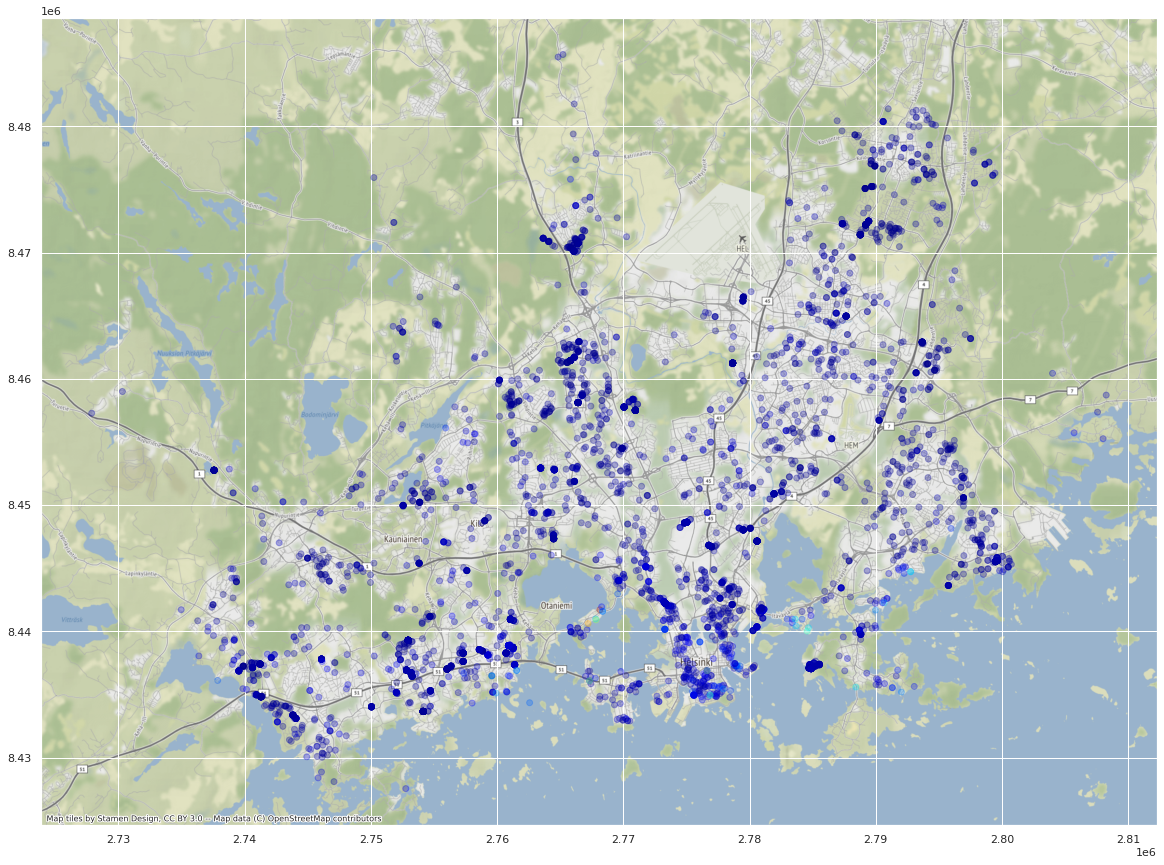

In [97]:
ax = housing_geo.plot(figsize=(20, 20), column=housing_geo.Price, cmap=plt.get_cmap("jet"), alpha=0.3)
ctx.add_basemap(ax)

Text(0.5, 1.0, 'Price for <2M€ housing in Helsinki, Espoo and Vantaa')

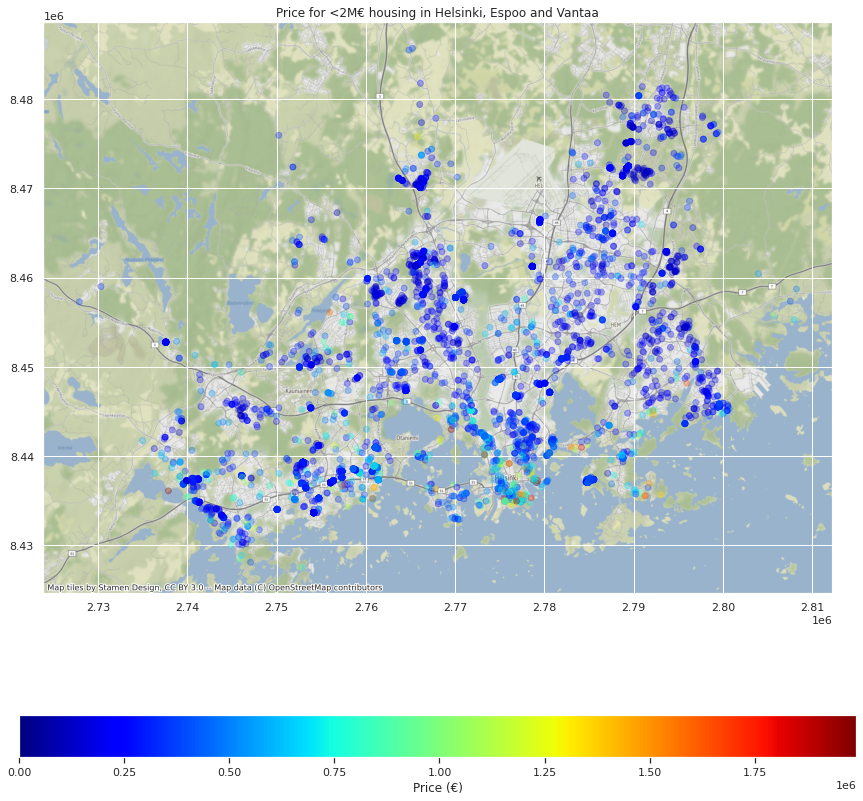

In [115]:
ax = housing_geo[housing_geo.Price<=2e6].plot(figsize=(15, 15), 
                                              column=housing_geo[housing_geo.Price<=2e6].Price, 
                                              cmap=plt.get_cmap("jet"), 
                                              alpha=0.3,
                                              legend=True,
                                              legend_kwds={'label': "Price (€)",
                                                           'orientation': "horizontal"})
ctx.add_basemap(ax)
plt.title("Price for <2M€ housing in Helsinki, Espoo and Vantaa")

In the latest map, we can appreciate high density clusters of similar price which likely correspond to new buildings that have been recently built and have just entered the market. It is also easy to see the high value properties located in the center of Helsinki and, in certain cases, spread throughout the shore.

Text(0.5, 1.0, 'Price for >2M€ housing in Helsinki, Espoo and Vantaa')

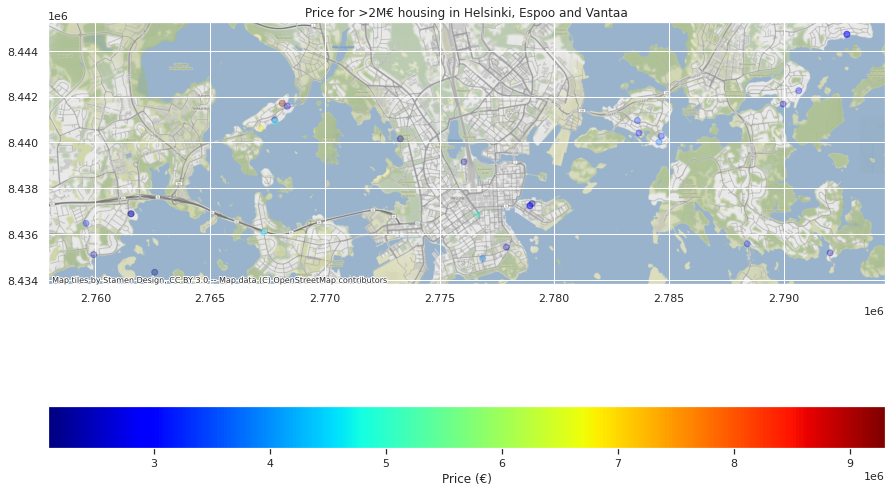

In [116]:
ax = housing_geo[housing_geo.Price>=2e6].plot(figsize=(15, 15), 
                                              column=housing_geo[housing_geo.Price>=2e6].Price, 
                                              cmap=plt.get_cmap("jet"), 
                                              alpha=0.3,
                                              legend=True,
                                              legend_kwds={'label': "Price (€)",
                                                           'orientation': "horizontal"})
ctx.add_basemap(ax)
plt.title("Price for >2M€ housing in Helsinki, Espoo and Vantaa")

Looking at the map, we can see how the most expensive houses are in very different areas with direct access to water and larger living area.

In [119]:
housing[housing.Price>=2e6].describe()

Price        Size         Year  Total_rooms   Latitude  Longitude
count  3.600000e+01   36.000000    36.000000    29.000000  29.000000  29.000000
mean   3.352583e+06  301.325000  1972.166667     5.758621  60.175067  24.939940
std    1.427768e+06  150.705849    50.552095     2.115507   0.013234   0.096278
min    2.090000e+06  122.500000  1898.000000     3.000000  60.155061  24.789785
25%    2.467500e+06  218.625000  1914.750000     4.000000  60.164595  24.863660
50%    2.985000e+06  260.250000  2000.000000     6.000000  60.176570  24.945162
75%    3.410000e+06  341.750000  2012.500000     7.000000  60.184621  25.014137
max    9.300000e+06  900.000000  2022.000000    12.000000  60.201410  25.087778

The highest valued properties are located in very different areas. Something  the all share is that they have a large size ($301\pm150\, m^2$), more rooms that the average household ($5.7\pm2.1$) and have a diverse set of years of construction ($1972\pm50$).

## Looking for correlations

In [36]:
corr_mat = housing.corr()
corr_mat

Price      Size      Year  Total_rooms  Latitude  Longitude
Price        1.000000  0.721781 -0.102507     0.447501 -0.281566  -0.025807
Size         0.721781  1.000000 -0.209697     0.815967 -0.082897  -0.022744
Year        -0.102507 -0.209697  1.000000    -0.081013  0.036972  -0.196787
Total_rooms  0.447501  0.815967 -0.081013     1.000000 -0.023466  -0.031596
Latitude    -0.281566 -0.082897  0.036972    -0.023466  1.000000   0.445697
Longitude   -0.025807 -0.022744 -0.196787    -0.031596  0.445697   1.000000

Let's look at the linear correlation of each attribute with the dependent variable: Price.

In [35]:
corr_mat.Price.sort_values(ascending=False)

Price          1.000000
Size           0.721781
Total_rooms    0.447501
Longitude     -0.025807
Year          -0.102507
Latitude      -0.281566
Name: Price, dtype: float64

We can see how there is a strong correlation between teh size of the house and the price. This is to be expected as bigger huosing is more expensive, obviously. The number of rooms is also positively correlated. 

The year that the building was constructed only seems to have a slight negative correlation. This correlation is likely not strong as old buildings tend to have better locations (e.g. center) than newer buildings.

The latitude (higher latitude, more north in this hemisphere) seems to be negatively correlated as the more expensive buildings are in the south, near the coast. The longitude does not seem to carry a large weight in the price.

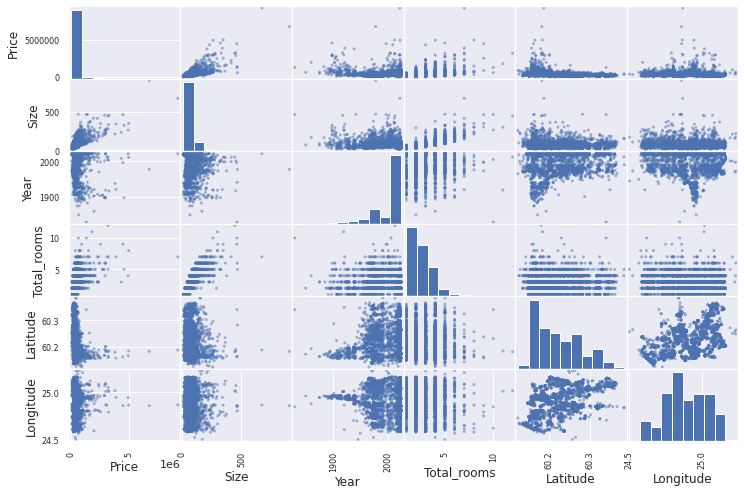

In [39]:
scatter_matrix(housing, figsize=(12, 8));

In [9]:
import geopy

In [8]:
from geopy.distance import vincenty

ImportError: cannot import name 'vincenty' from 'geopy.distance' (C:\Users\Alberto\anaconda3\envs\houseprice\lib\site-packages\geopy\distance.py)

In [4]:
housing.head()

Link  \
0  https://www.etuovi.com/kohde/21189890?haku=M16...   
1  https://www.etuovi.com/kohde/7971959?haku=M160...   
2  https://www.etuovi.com/kohde/21772126?haku=M16...   
3  https://www.etuovi.com/kohde/1287367?haku=M160...   
4  https://www.etuovi.com/kohde/20553097?haku=M16...   

                                      Address   Price  Size  Year  House_type  \
0         Rosendalinrinki 3, Tammisto, Vantaa  227000  49.5  2009  Kerrostalo   
1         Kanttiinitie 6 B4, Painiitty, Espoo  385900  92.0  2022    Rivitalo   
2         Konalantie 4, Pitäjänmäki, Helsinki  205000  66.0  1963  Kerrostalo   
3  Ripusuontie 64 A 2, Länsi-Pakila, Helsinki  545000  92.0  2020    Rivitalo   
4        Kievarinraitti 2, Viherlaakso, Espoo  149000  56.0  1980  Kerrostalo   

                                         Description  Total_rooms   Latitude  \
0                                        2h + kt + s          2.0  60.268798   
1                                        4h + kt + s          4.0  60.237447   
2                                             3h + k          3.0  60.225724   
3   3-4h, k, kph / 2wc, khh, sauna, vh 92 m2 + lä...          3.0  60.247235   
4           2h + k + kph + wc (yht.järj.muk. 2h + k)          2.0  60.229167   

   Longitude  
0  24.968812  
1  24.834287  
2  24.853692  
3  24.945488  
4  24.742285

In [11]:
housing.loc[0].Longitude

24.968811530301256

In [27]:
Vantaa_loc = (housing.loc[0].Latitude, housing.loc[0].Longitude)
Espoo_loc = (housing.loc[1].Latitude, housing.loc[1].Longitude)

In [28]:
geopy.distance.geodesic(Vantaa_loc, Espoo_loc).km

8.227352838021135

In [ ]:
geopy.distance.vincenty(housing.loc[, coords_2).km

In [14]:
housing.loc[0].Address

'Rosendalinrinki 3, Tammisto, Vantaa'

In [15]:
housing.loc[1].Address

'Kanttiinitie 6 B4, Painiitty, Espoo'

In [21]:
Vantaa_loc

(24.968811530301256, 60.26879805)

In [22]:
housing.loc[0].Latitude

60.26879805

### Mean price implementation

In [51]:
housing_subset = housing[housing.Latitude.notnull() & housing.Longitude.notnull()]

In [52]:
housing_subset.reset_index(inplace=True, drop=True)

In [53]:
len(housing_subset)

4584

In [54]:
housing_subset.head(n=10)

Link  \
0  https://www.etuovi.com/kohde/21189890?haku=M16...   
1  https://www.etuovi.com/kohde/7971959?haku=M160...   
2  https://www.etuovi.com/kohde/21772126?haku=M16...   
3  https://www.etuovi.com/kohde/1287367?haku=M160...   
4  https://www.etuovi.com/kohde/20553097?haku=M16...   
5  https://www.etuovi.com/kohde/q48629?haku=M1606...   
6  https://www.etuovi.com/kohde/1291881?haku=M160...   
7  https://www.etuovi.com/kohde/21102389?haku=M16...   
8  https://www.etuovi.com/kohde/20777635?haku=M16...   
9  https://www.etuovi.com/kohde/1292095?haku=M160...   

                                      Address   Price   Size  Year  \
0         Rosendalinrinki 3, Tammisto, Vantaa  227000   49.5  2009   
1         Kanttiinitie 6 B4, Painiitty, Espoo  385900   92.0  2022   
2         Konalantie 4, Pitäjänmäki, Helsinki  205000   66.0  1963   
3  Ripusuontie 64 A 2, Länsi-Pakila, Helsinki  545000   92.0  2020   
4        Kievarinraitti 2, Viherlaakso, Espoo  149000   56.0  1980   
5       Melkonkuja 1 C, Lauttasaari, Helsinki  839000  115.5  2005   
6       Satamasaarentie 2, Vuosaari, Helsinki  198000   78.0  1966   
7               Majavatie 23, Metsola, Vantaa  235000   73.5  1987   
8            Maauunintie 18, Kulomäki, Vantaa  135000   75.0  1975   
9          Helsinginkatu 15, Kallio, Helsinki  385000   65.5  1929   

   House_type                                        Description  Total_rooms  \
0  Kerrostalo                                        2h + kt + s          2.0   
1    Rivitalo                                        4h + kt + s          4.0   
2  Kerrostalo                                             3h + k          3.0   
3    Rivitalo   3-4h, k, kph / 2wc, khh, sauna, vh 92 m2 + lä...          3.0   
4  Kerrostalo           2h + k + kph + wc (yht.järj.muk. 2h + k)          2.0   
5  Kerrostalo                                         4H + K + S          4.0   
6  Kerrostalo                  4h + k + kph + erill.wc + parveke          4.0   
7    Paritalo   Yhtiöjärj. 3h + k + s + kph + wc ( + käyttöul...          NaN   
8   Luhtitalo                                             3h + k          3.0   
9  Kerrostalo                       2h + k + halli + kph + sauna          2.0   

    Latitude  Longitude  
0  60.268798  24.968812  
1  60.237447  24.834287  
2  60.225724  24.853692  
3  60.247235  24.945488  
4  60.229167  24.742285  
5  60.149393  24.885209  
6  60.212681  25.135564  
7  60.348649  25.092881  
8  60.344533  25.062293  
9  60.181763  24.943394

In [62]:
# 5 km maximum distance, top 20 nearest buildings
distances = []
i_list = []
j_list = []
for i in range(len(housing_subset)):
    for j in range(len(housing_subset)):
        if i != j:
            #print("i", i,  (housing_subset.loc[i].Latitude, housing_subset.loc[i].Longitude))
            #print("j", j, (housing_subset.loc[j].Latitude, housing_subset.loc[j].Longitude))
            i_loc = (housing_subset.loc[i].Latitude, housing_subset.loc[i].Longitude)
            j_loc = (housing_subset.loc[j].Latitude, housing_subset.loc[j].Longitude)
            distance = geopy.distance.geodesic(i_loc, j_loc).km
            #print("distance", distance)
            distances.append(distance)
            i_list.append(i)
            j_list.append(j)

KeyboardInterrupt: 

In [63]:
distances = []
i_list = []
j_list = []
i = 0
for j in range(len(housing_subset)):
    if i != j:
        #print("i", i,  (housing_subset.loc[i].Latitude, housing_subset.loc[i].Longitude))
        #print("j", j, (housing_subset.loc[j].Latitude, housing_subset.loc[j].Longitude))
        i_loc = (housing_subset.loc[i].Latitude, housing_subset.loc[i].Longitude)
        j_loc = (housing_subset.loc[j].Latitude, housing_subset.loc[j].Longitude)
        distance = geopy.distance.geodesic(i_loc, j_loc).km
        #print("distance", distance)
        distances.append(distance)
        i_list.append(i)
        j_list.append(j)

In [64]:
temp_dist_df = pd.DataFrame(data={"i": i_list, "j": j_list, "dist": distances})
temp_dist_df.head(20)

i   j       dist
0   0   1   8.227353
1   0   2   7.980066
2   0   3   2.727556
3   0   4  13.299460
4   0   5  14.088055
5   0   6  11.154161
6   0   7  11.233463
7   0   8   9.894996
8   0   9   9.798860
9   0  10  11.481038
10  0  11  17.350701
11  0  12  11.217680
12  0  13  13.012562
13  0  14   9.951978
14  0  15   7.514699
15  0  16   9.408842
16  0  17  13.429487
17  0  18   4.602227
18  0  19   8.247874
19  0  20  10.348796

In [ ]:
for i in range(len(temp_dist_df)):
    neighbors = temp_dist_df[temp_dist_df.dist <= 5.00]
    sorted_neighbors = neighbors.sort_values()

In [69]:
housing_subset_sorted = housing_subset.sort_values(['Latitude', 'Longitude'], inplace=False, ignore_index=True)

In [70]:
housing_subset_sorted.head()

Link  \
0  https://www.etuovi.com/kohde/9949701?haku=M160...   
1  https://www.etuovi.com/kohde/20829373?haku=M16...   
2  https://www.etuovi.com/kohde/7970442?haku=M160...   
3  https://www.etuovi.com/kohde/9762965?haku=M160...   
4  https://www.etuovi.com/kohde/21522404?haku=M16...   

                               Address   Price   Size  Year   House_type  \
0  Felsundintie 4, Suvisaaristo, Espoo  890000  260.0  1965  Omakotitalo   
1     Kilvoituksentie 4, Soukka, Espoo  398000   96.5  2018     Rivitalo   
2          Soukan rantatie 25 A, Espoo  880000  231.0  2000     Paritalo   
3    Soukansalmentie 10, Soukka, Espoo  689000  213.0  1992  Erillistalo   
4     Alakartanonkuja 1, Soukka, Espoo  338000  110.0  1976     Rivitalo   

                                         Description  Total_rooms   Latitude  \
0                                                NaN          NaN  60.124636   
1   4-5h + k + s + terassi, piha (yhtiöjärj. muka...          4.0  60.127107   
2   4 h, k, takkahuone, 2 kph, 2 wc, harrastehuon...          4.0  60.128454   
3                  5-6h + k + kph + s + rh + s + khh          5.0  60.130518   
4                  4H + K + S + VH + 2 WC + PH + VAR          4.0  60.135745   

   Longitude  
0  24.728589  
1  24.677484  
2  24.666219  
3  24.668579  
4  24.669064

In [ ]:
len = 200
i = 185
end_idx = 210
start_idx = 160


In [117]:
for i in range(len(housing_subset_sorted) - 1):
    distances = []
    i_list = []
    j_list = []
    start_idx = i - 25
    end_idx = i + 25
    
    if start_idx < 0:
        end_idx += np.abs(start_idx)
        start_idx = 0
        
    if end_idx > len(housing_subset_sorted):
        start_idx -= (end_idx - len(housing_subset_sorted) - 1)
        end_idx = len(housing_subset_sorted) - 1
    
    end_idx = min(end_idx, len(housing_subset_sorted) - 1)
    start_idx = max(start_idx, 0)
     
    for j in range(start_idx, end_idx):
        if i != j:
            i_loc = (housing_subset_sorted.loc[i].Latitude, housing_subset_sorted.loc[i].Longitude)
            j_loc = (housing_subset_sorted.loc[j].Latitude, housing_subset_sorted.loc[j].Longitude)
            distance = geopy.distance.geodesic(i_loc, j_loc).km

            distances.append(distance)
            i_list.append(i)
            j_list.append(j)

    temp_dist_df = pd.DataFrame(data={"i": i_list, "j": j_list, "dist": distances})

    temp_dist_df = temp_dist_df[temp_dist_df.dist < 10.0]

    temp_sorted = temp_dist_df.sort_values("dist", inplace=False, ignore_index=True)

    temp_subset = temp_sorted[:20]

    if len(temp_subset) > 0:
        mean_price_neighbors = housing_subset_sorted.iloc[temp_subset.j].Price.mean() / housing_subset_sorted.iloc[temp_subset.j].Size.mean()
    else:
         mean_price_neighbors = housing_subset_sorted.iloc[i].Price / housing_subset_sorted.iloc[i].Size

    # Add mean price from 20 nearest and less than 10 km far
    housing_subset_sorted.loc[i, "Mean_price_per_sqm"] = np.round(mean_price_neighbors, decimals=3)
    print(f"Average price/sqm for {i} is {mean_price_neighbors}.")

Average price/sqm for 0 is 3892.0036764705883.
Average price/sqm for 1 is 3585.0484977525434.
Average price/sqm for 2 is 3585.1440121273367.
Average price/sqm for 3 is 3648.4727090635956.
Average price/sqm for 4 is 3636.6666666666665.
Average price/sqm for 5 is 3468.298653610771.
Average price/sqm for 6 is 3581.2005583992554.
Average price/sqm for 7 is 3912.4087591240877.
Average price/sqm for 8 is 3790.443006470881.
Average price/sqm for 9 is 3859.481238982624.
Average price/sqm for 10 is 3859.720457433291.
Average price/sqm for 11 is 3877.6470588235293.
Average price/sqm for 12 is 3316.488004083716.
Average price/sqm for 13 is 4127.928402211109.
Average price/sqm for 14 is 3522.4327018943172.
Average price/sqm for 15 is 3954.285714285714.
Average price/sqm for 16 is 3993.3902506196637.
Average price/sqm for 17 is 4010.744023636852.
Average price/sqm for 18 is 4223.417883679221.
Average price/sqm for 19 is 4011.305460750853.
Average price/sqm for 20 is 3972.330984077264.
Average price

Average price/sqm for 178 is 5182.487725040916.
Average price/sqm for 179 is 4988.2400648824005.
Average price/sqm for 180 is 5007.85075787019.
Average price/sqm for 181 is 5777.853203224438.
Average price/sqm for 182 is 5844.327176781003.
Average price/sqm for 183 is 5831.486367634125.
Average price/sqm for 184 is 5860.334212840809.
Average price/sqm for 185 is 5866.754617414248.
Average price/sqm for 186 is 5808.275261324042.
Average price/sqm for 187 is 5802.26480836237.
Average price/sqm for 188 is 5801.8973695558425.
Average price/sqm for 189 is 5875.656430796618.
Average price/sqm for 190 is 5837.906772207563.
Average price/sqm for 191 is 5801.8973695558425.
Average price/sqm for 192 is 5813.971539456662.
Average price/sqm for 193 is 5835.104529616725.
Average price/sqm for 194 is 5806.727037516171.
Average price/sqm for 195 is 5817.247386759582.
Average price/sqm for 196 is 5794.307891332471.
Average price/sqm for 197 is 5794.307891332471.
Average price/sqm for 198 is 5806.72703

Average price/sqm for 353 is 5590.264304171282.
Average price/sqm for 354 is 5545.79226519337.
Average price/sqm for 355 is 5710.019950124689.
Average price/sqm for 356 is 5688.668636867382.
Average price/sqm for 357 is 5749.920199501247.
Average price/sqm for 358 is 5747.070181688636.
Average price/sqm for 359 is 5781.542245989305.
Average price/sqm for 360 is 5778.299644128114.
Average price/sqm for 361 is 5716.919188323248.
Average price/sqm for 362 is 5732.107588172426.
Average price/sqm for 363 is 5622.614874815905.
Average price/sqm for 364 is 5710.455856489623.
Average price/sqm for 365 is 5605.029900332227.
Average price/sqm for 366 is 5574.022148394242.
Average price/sqm for 367 is 5750.978330373002.
Average price/sqm for 368 is 5721.008090045726.
Average price/sqm for 369 is 5774.857855361596.
Average price/sqm for 370 is 5793.268327402135.
Average price/sqm for 371 is 5796.849110320285.
Average price/sqm for 372 is 5796.849110320285.
Average price/sqm for 373 is 8848.6532514

Average price/sqm for 525 is 6919.362101313322.
Average price/sqm for 526 is 6945.913563218391.
Average price/sqm for 527 is 6949.704977375566.
Average price/sqm for 528 is 6705.6129343629345.
Average price/sqm for 529 is 6741.686947988223.
Average price/sqm for 530 is 6695.928229665072.
Average price/sqm for 531 is 6772.953557312253.
Average price/sqm for 532 is 6766.100574712644.
Average price/sqm for 533 is 6815.148406374502.
Average price/sqm for 534 is 6815.148406374502.
Average price/sqm for 535 is 6815.269539078156.
Average price/sqm for 536 is 6815.269539078156.
Average price/sqm for 537 is 6801.127218934911.
Average price/sqm for 538 is 6790.27909270217.
Average price/sqm for 539 is 6721.698037242073.
Average price/sqm for 540 is 6748.616691654172.
Average price/sqm for 541 is 6717.688082393331.
Average price/sqm for 542 is 6706.397817460318.
Average price/sqm for 543 is 6719.079840319361.
Average price/sqm for 544 is 6741.770114942528.
Average price/sqm for 545 is 6748.648406

Average price/sqm for 697 is 5357.713583282115.
Average price/sqm for 698 is 5311.03133159269.
Average price/sqm for 699 is 5212.693193028608.
Average price/sqm for 700 is 5217.527386541471.
Average price/sqm for 701 is 5192.909613541999.
Average price/sqm for 702 is 5218.941137783623.
Average price/sqm for 703 is 5243.821579264617.
Average price/sqm for 704 is 5243.821579264617.
Average price/sqm for 705 is 5307.116788321167.
Average price/sqm for 706 is 5192.909613541999.
Average price/sqm for 707 is 5111.496888306583.
Average price/sqm for 708 is 5277.925363693865.
Average price/sqm for 709 is 5292.19589257504.
Average price/sqm for 710 is 5290.575585072739.
Average price/sqm for 711 is 5311.1532385466035.
Average price/sqm for 712 is 5282.100092109304.
Average price/sqm for 713 is 5219.728729963009.
Average price/sqm for 714 is 5187.7994251038.
Average price/sqm for 715 is 5198.962722852512.
Average price/sqm for 716 is 5295.28436696199.
Average price/sqm for 717 is 5259.6778916544

Average price/sqm for 873 is 6222.161084529505.
Average price/sqm for 874 is 6120.805422647528.
Average price/sqm for 875 is 6114.152373354607.
Average price/sqm for 876 is 6137.369042930287.
Average price/sqm for 877 is 6129.019298936589.
Average price/sqm for 878 is 6104.474497681607.
Average price/sqm for 879 is 6664.864376130199.
Average price/sqm for 880 is 7298.958128078818.
Average price/sqm for 881 is 5207.178347578348.
Average price/sqm for 882 is 5444.413307240705.
Average price/sqm for 883 is 5376.549508692366.
Average price/sqm for 884 is 5382.091458805744.
Average price/sqm for 885 is 5364.279909706546.
Average price/sqm for 886 is 5369.3127587504705.
Average price/sqm for 887 is 5374.406473466316.
Average price/sqm for 888 is 5379.500940910802.
Average price/sqm for 889 is 5412.8403041825095.
Average price/sqm for 890 is 5405.824453813722.
Average price/sqm for 891 is 5412.8823303947875.
Average price/sqm for 892 is 5439.293163383546.
Average price/sqm for 893 is 5484.710

Average price/sqm for 1050 is 6986.3556338028175.
Average price/sqm for 1051 is 4244.186615495322.
Average price/sqm for 1052 is 3858.4781202845443.
Average price/sqm for 1053 is 3931.251355454348.
Average price/sqm for 1054 is 6842.712933753944.
Average price/sqm for 1055 is 5064.107744107744.
Average price/sqm for 1056 is 4969.941800753167.
Average price/sqm for 1057 is 4829.816201497617.
Average price/sqm for 1058 is 5182.658959537573.
Average price/sqm for 1059 is 6859.936760744818.
Average price/sqm for 1060 is 6816.724738675958.
Average price/sqm for 1061 is 6732.626986600188.
Average price/sqm for 1062 is 4379.738968303293.
Average price/sqm for 1063 is 7078.069342199003.
Average price/sqm for 1064 is 6915.01881628464.
Average price/sqm for 1065 is 4325.427530137371.
Average price/sqm for 1066 is 4291.918604651163.
Average price/sqm for 1067 is 6849.03390722502.
Average price/sqm for 1068 is 5696.858385693572.
Average price/sqm for 1069 is 5758.027176648214.
Average price/sqm fo

Average price/sqm for 1222 is 8528.095047923323.
Average price/sqm for 1223 is 8574.061767005473.
Average price/sqm for 1224 is 8460.902527075812.
Average price/sqm for 1225 is 8487.71551724138.
Average price/sqm for 1226 is 8387.98831690398.
Average price/sqm for 1227 is 8378.968995143818.
Average price/sqm for 1228 is 8406.653144016227.
Average price/sqm for 1229 is 8353.309831570701.
Average price/sqm for 1230 is 8398.064516129032.
Average price/sqm for 1231 is 8630.732113144759.
Average price/sqm for 1232 is 8332.369095569387.
Average price/sqm for 1233 is 8343.008910212475.
Average price/sqm for 1234 is 8330.48696844993.
Average price/sqm for 1235 is 8243.210332103321.
Average price/sqm for 1236 is 8169.1788126555275.
Average price/sqm for 1237 is 8113.981547196593.
Average price/sqm for 1238 is 8089.892402999674.
Average price/sqm for 1239 is 8039.668367346938.
Average price/sqm for 1240 is 7956.152050683561.
Average price/sqm for 1241 is 7918.455931080185.
Average price/sqm for 

Average price/sqm for 1394 is 5139.55369595537.
Average price/sqm for 1395 is 5109.791477787851.
Average price/sqm for 1396 is 5140.704091341579.
Average price/sqm for 1397 is 5112.043583535109.
Average price/sqm for 1398 is 5201.401643305945.
Average price/sqm for 1399 is 5226.346243583761.
Average price/sqm for 1400 is 5332.131578947368.
Average price/sqm for 1401 is 5293.616817964644.
Average price/sqm for 1402 is 5246.797372410308.
Average price/sqm for 1403 is 5305.244157135754.
Average price/sqm for 1404 is 5458.228409627183.
Average price/sqm for 1405 is 5470.1283753873395.
Average price/sqm for 1406 is 5384.0209758321935.
Average price/sqm for 1407 is 5495.994718309859.
Average price/sqm for 1408 is 5523.3627946127945.
Average price/sqm for 1409 is 5174.017591339648.
Average price/sqm for 1410 is 5060.80559646539.
Average price/sqm for 1411 is 4976.547680890539.
Average price/sqm for 1412 is 5031.274281805746.
Average price/sqm for 1413 is 6635.763774331905.
Average price/sqm f

Average price/sqm for 1565 is 8927.061917284245.
Average price/sqm for 1566 is 8968.802714894671.
Average price/sqm for 1567 is 6490.328888888889.
Average price/sqm for 1568 is 6559.942611190818.
Average price/sqm for 1569 is 6589.1571709233785.
Average price/sqm for 1570 is 6596.865134865135.
Average price/sqm for 1571 is 6535.179736970286.
Average price/sqm for 1572 is 6516.602150537635.
Average price/sqm for 1573 is 8253.993993993994.
Average price/sqm for 1574 is 8270.176548540161.
Average price/sqm for 1575 is 7373.27935222672.
Average price/sqm for 1576 is 6963.759664025961.
Average price/sqm for 1577 is 8237.068188396806.
Average price/sqm for 1578 is 8178.345031400073.
Average price/sqm for 1579 is 8486.847127798916.
Average price/sqm for 1580 is 6994.736842105263.
Average price/sqm for 1581 is 6971.458662453923.
Average price/sqm for 1582 is 6982.40499739719.
Average price/sqm for 1583 is 7029.725530813051.
Average price/sqm for 1584 is 6987.054026503568.
Average price/sqm for

Average price/sqm for 1734 is 9341.097308488614.
Average price/sqm for 1735 is 9131.675783192442.
Average price/sqm for 1736 is 8977.52808988764.
Average price/sqm for 1737 is 8927.415399705738.
Average price/sqm for 1738 is 8960.07944389275.
Average price/sqm for 1739 is 8943.795978420794.
Average price/sqm for 1740 is 9037.884130982367.
Average price/sqm for 1741 is 8608.256382400868.
Average price/sqm for 1742 is 4055.9322033898306.
Average price/sqm for 1743 is 7571.199286669638.
Average price/sqm for 1744 is 8938.989700833741.
Average price/sqm for 1745 is 8394.446781657552.
Average price/sqm for 1746 is 8394.446781657552.
Average price/sqm for 1747 is 8802.20588235294.
Average price/sqm for 1748 is 8513.610503282276.
Average price/sqm for 1749 is 8558.018252933507.
Average price/sqm for 1750 is 8483.2.
Average price/sqm for 1751 is 8553.967558088558.
Average price/sqm for 1752 is 8517.738454898576.
Average price/sqm for 1753 is 8318.567311650884.
Average price/sqm for 1754 is 830

Average price/sqm for 1903 is 6004.506643432804.
Average price/sqm for 1904 is 5958.355620559967.
Average price/sqm for 1905 is 6745.70073072309.
Average price/sqm for 1906 is 6957.468780540776.
Average price/sqm for 1907 is 7289.4734243870325.
Average price/sqm for 1908 is 7363.362482853223.
Average price/sqm for 1909 is 6274.811618606608.
Average price/sqm for 1910 is 6239.695025765064.
Average price/sqm for 1911 is 6443.583377169911.
Average price/sqm for 1912 is 6411.240383602065.
Average price/sqm for 1913 is 6340.228983688833.
Average price/sqm for 1914 is 6290.782327135994.
Average price/sqm for 1915 is 4640.52678838671.
Average price/sqm for 1916 is 4549.108204518431.
Average price/sqm for 1917 is 4535.0165314096785.
Average price/sqm for 1918 is 4510.597418192735.
Average price/sqm for 1919 is 4521.85151788398.
Average price/sqm for 1920 is 4598.129713423831.
Average price/sqm for 1921 is 6125.975585351211.
Average price/sqm for 1922 is 6126.044582167134.
Average price/sqm for

Average price/sqm for 2075 is 3803.2472863267362.
Average price/sqm for 2076 is 3696.5290806754224.
Average price/sqm for 2077 is 4621.722648479682.
Average price/sqm for 2078 is 7856.586519766688.
Average price/sqm for 2079 is 6015.760799066026.
Average price/sqm for 2080 is 4401.077114280642.
Average price/sqm for 2081 is 4403.453596012342.
Average price/sqm for 2082 is 4403.266852103923.
Average price/sqm for 2083 is 4397.348641770728.
Average price/sqm for 2084 is 4523.949662450023.
Average price/sqm for 2085 is 7808.225657894737.
Average price/sqm for 2086 is 7558.502896081772.
Average price/sqm for 2087 is 7636.835290171083.
Average price/sqm for 2088 is 7615.809362279511.
Average price/sqm for 2089 is 7586.509920634921.
Average price/sqm for 2090 is 7583.039447731756.
Average price/sqm for 2091 is 7594.719491808759.
Average price/sqm for 2092 is 7008.787146226416.
Average price/sqm for 2093 is 7344.807333547766.
Average price/sqm for 2094 is 7369.8753164556965.
Average price/sqm

Average price/sqm for 2246 is 6702.262645914397.
Average price/sqm for 2247 is 4170.234779148428.
Average price/sqm for 2248 is 5186.932409012132.
Average price/sqm for 2249 is 6817.34017595308.
Average price/sqm for 2250 is 4160.746979128524.
Average price/sqm for 2251 is 3657.5245579567777.
Average price/sqm for 2252 is 6755.143931256714.
Average price/sqm for 2253 is 6746.1213748657365.
Average price/sqm for 2254 is 6821.638938053097.
Average price/sqm for 2255 is 6750.560137457045.
Average price/sqm for 2256 is 6736.127147766323.
Average price/sqm for 2257 is 6785.801491681009.
Average price/sqm for 2258 is 6821.768115942028.
Average price/sqm for 2259 is 6686.714211348257.
Average price/sqm for 2260 is 6569.144794188862.
Average price/sqm for 2261 is 6573.243482538121.
Average price/sqm for 2262 is 6542.863323500491.
Average price/sqm for 2263 is 6566.0688298918385.
Average price/sqm for 2264 is 6508.914122137404.
Average price/sqm for 2265 is 6504.906488549618.
Average price/sqm 

Average price/sqm for 2419 is 4706.267029972752.
Average price/sqm for 2420 is 4667.082294264339.
Average price/sqm for 2421 is 4708.196721311476.
Average price/sqm for 2422 is 4758.978583196046.
Average price/sqm for 2423 is 4711.86440677966.
Average price/sqm for 2424 is 4697.295115058539.
Average price/sqm for 2425 is 4680.145278450363.
Average price/sqm for 2426 is 4768.215767634855.
Average price/sqm for 2427 is 4760.851760851761.
Average price/sqm for 2428 is 2917.984197530864.
Average price/sqm for 2429 is 4371.493902439025.
Average price/sqm for 2430 is 4383.752417794971.
Average price/sqm for 2431 is 4406.491499227202.
Average price/sqm for 2432 is 4476.745082915541.
Average price/sqm for 2433 is 3270.8978518193776.
Average price/sqm for 2434 is 4170.889204545455.
Average price/sqm for 2435 is 3843.5199637023593.
Average price/sqm for 2436 is 4259.623637887678.
Average price/sqm for 2437 is 4566.319845857418.
Average price/sqm for 2438 is 4500.23130300694.
Average price/sqm fo

Average price/sqm for 2592 is 5180.681114551084.
Average price/sqm for 2593 is 5221.1625478593805.
Average price/sqm for 2594 is 5214.42394709363.
Average price/sqm for 2595 is 3498.7994065910775.
Average price/sqm for 2596 is 4594.496686651941.
Average price/sqm for 2597 is 3876.8454193191255.
Average price/sqm for 2598 is 3773.1859604157767.
Average price/sqm for 2599 is 5235.356527729934.
Average price/sqm for 2600 is 5215.314518871131.
Average price/sqm for 2601 is 5102.492897727272.
Average price/sqm for 2602 is 5102.492897727272.
Average price/sqm for 2603 is 5102.492897727272.
Average price/sqm for 2604 is 5209.737670514166.
Average price/sqm for 2605 is 5217.740468695349.
Average price/sqm for 2606 is 5225.12766701644.
Average price/sqm for 2607 is 5195.0499827645635.
Average price/sqm for 2608 is 5163.404255319148.
Average price/sqm for 2609 is 5204.893470790378.
Average price/sqm for 2610 is 5191.349066572738.
Average price/sqm for 2611 is 5193.556019485039.
Average price/sqm

Average price/sqm for 2764 is 2832.682060390764.
Average price/sqm for 2765 is 2849.5386799148337.
Average price/sqm for 2766 is 4365.523404255319.
Average price/sqm for 2767 is 3700.8141547535097.
Average price/sqm for 2768 is 2973.078170613039.
Average price/sqm for 2769 is 2954.336500153233.
Average price/sqm for 2770 is 3119.186675319057.
Average price/sqm for 2771 is 4229.614108482399.
Average price/sqm for 2772 is 4250.312037858621.
Average price/sqm for 2773 is 4266.814714102273.
Average price/sqm for 2774 is 4305.305766793409.
Average price/sqm for 2775 is 4181.700706388206.
Average price/sqm for 2776 is 4559.75744975745.
Average price/sqm for 2777 is 3868.9734249523963.
Average price/sqm for 2778 is 3010.880110880111.
Average price/sqm for 2779 is 3061.658735554045.
Average price/sqm for 2780 is 2966.7374810318665.
Average price/sqm for 2781 is 2982.563154651879.
Average price/sqm for 2782 is 3179.0743155149935.
Average price/sqm for 2783 is 3236.683738796415.
Average price/sq

Average price/sqm for 2936 is 3786.4667747163694.
Average price/sqm for 2937 is 3797.2323972323975.
Average price/sqm for 2938 is 3788.9833940866747.
Average price/sqm for 2939 is 3816.4383561643835.
Average price/sqm for 2940 is 3806.2628759785744.
Average price/sqm for 2941 is 3804.4226044226048.
Average price/sqm for 2942 is 3791.970802919708.
Average price/sqm for 2943 is 4202.638522427441.
Average price/sqm for 2944 is 4210.045662100457.
Average price/sqm for 2945 is 4224.810126582279.
Average price/sqm for 2946 is 4231.6.
Average price/sqm for 2947 is 4244.621513944223.
Average price/sqm for 2948 is 4262.311557788945.
Average price/sqm for 2949 is 4268.449727587915.
Average price/sqm for 2950 is 4262.311557788945.
Average price/sqm for 2951 is 4260.760760760761.
Average price/sqm for 2952 is 4260.760760760761.
Average price/sqm for 2953 is 4256.729810568295.
Average price/sqm for 2954 is 4265.4473554127535.
Average price/sqm for 2955 is 4265.4473554127535.
Average price/sqm for 2

Average price/sqm for 3103 is 5130.141843971632.
Average price/sqm for 3104 is 5019.681791396582.
Average price/sqm for 3105 is 3159.155990957046.
Average price/sqm for 3106 is 3237.037037037037.
Average price/sqm for 3107 is 3271.3196951464097.
Average price/sqm for 3108 is 4160.361938120257.
Average price/sqm for 3109 is 4324.113724113725.
Average price/sqm for 3110 is 4263.84431546603.
Average price/sqm for 3111 is 4216.039279869067.
Average price/sqm for 3112 is 4448.218317463434.
Average price/sqm for 3113 is 4429.074545098807.
Average price/sqm for 3114 is 4487.207785692786.
Average price/sqm for 3115 is 4429.340511440108.
Average price/sqm for 3116 is 4390.916303054343.
Average price/sqm for 3117 is 4085.0986782545715.
Average price/sqm for 3118 is 4120.569304686791.
Average price/sqm for 3119 is 4117.852868060031.
Average price/sqm for 3120 is 4132.211538461538.
Average price/sqm for 3121 is 4121.535770186907.
Average price/sqm for 3122 is 4118.883052253248.
Average price/sqm f

Average price/sqm for 3274 is 4127.919135587313.
Average price/sqm for 3275 is 4752.012882447665.
Average price/sqm for 3276 is 4782.31859883236.
Average price/sqm for 3277 is 4759.031198686371.
Average price/sqm for 3278 is 4757.761437908496.
Average price/sqm for 3279 is 4741.127348643006.
Average price/sqm for 3280 is 4695.697211155379.
Average price/sqm for 3281 is 4714.747634069401.
Average price/sqm for 3282 is 4650.242718446602.
Average price/sqm for 3283 is 4614.346317007327.
Average price/sqm for 3284 is 4611.298548450372.
Average price/sqm for 3285 is 4596.266044340723.
Average price/sqm for 3286 is 4565.517241379311.
Average price/sqm for 3287 is 4574.27701674277.
Average price/sqm for 3288 is 4581.41351034752.
Average price/sqm for 3289 is 4574.0008074283405.
Average price/sqm for 3290 is 4586.860706860707.
Average price/sqm for 3291 is 4673.939892960066.
Average price/sqm for 3292 is 4612.1660501438555.
Average price/sqm for 3293 is 4572.2679200940065.
Average price/sqm fo

Average price/sqm for 3446 is 4392.979127134725.
Average price/sqm for 3447 is 4459.902597402597.
Average price/sqm for 3448 is 4593.2692307692305.
Average price/sqm for 3449 is 3771.1940778886387.
Average price/sqm for 3450 is 3697.4662162162163.
Average price/sqm for 3451 is 3823.2535257461464.
Average price/sqm for 3452 is 3716.409423233144.
Average price/sqm for 3453 is 3656.484641638225.
Average price/sqm for 3454 is 3534.1704718417045.
Average price/sqm for 3455 is 3477.1282856021967.
Average price/sqm for 3456 is 3413.3535660091043.
Average price/sqm for 3457 is 3417.6824680210684.
Average price/sqm for 3458 is 4251.721584598296.
Average price/sqm for 3459 is 4193.143056038984.
Average price/sqm for 3460 is 4248.298611111111.
Average price/sqm for 3461 is 3900.740491417031.
Average price/sqm for 3462 is 4195.406871609403.
Average price/sqm for 3463 is 4213.247232472325.
Average price/sqm for 3464 is 3494.389689158453.
Average price/sqm for 3465 is 2972.893772893773.
Average pric

Average price/sqm for 3614 is 2519.6323816973018.
Average price/sqm for 3615 is 2524.534161490683.
Average price/sqm for 3616 is 2511.124354390147.
Average price/sqm for 3617 is 3378.8953741074197.
Average price/sqm for 3618 is 2476.9801014436207.
Average price/sqm for 3619 is 2453.6860198624904.
Average price/sqm for 3620 is 2839.1570360299115.
Average price/sqm for 3621 is 3309.889623265036.
Average price/sqm for 3622 is 3825.2141918528255.
Average price/sqm for 3623 is 2138.150087260035.
Average price/sqm for 3624 is 2155.0283286118984.
Average price/sqm for 3625 is 2206.0014461315977.
Average price/sqm for 3626 is 2077.5792927451694.
Average price/sqm for 3627 is 2162.734288864388.
Average price/sqm for 3628 is 2172.0844131803033.
Average price/sqm for 3629 is 2236.5458750963767.
Average price/sqm for 3630 is 4467.149881046788.
Average price/sqm for 3631 is 3849.1900334696916.
Average price/sqm for 3632 is 3919.7653802063433.
Average price/sqm for 3633 is 3939.497487437186.
Average

Average price/sqm for 3785 is 4770.649704679691.
Average price/sqm for 3786 is 4754.2342342342345.
Average price/sqm for 3787 is 4807.390300230947.
Average price/sqm for 3788 is 4807.196261682243.
Average price/sqm for 3789 is 4774.092788240699.
Average price/sqm for 3790 is 4576.091751213057.
Average price/sqm for 3791 is 4386.046511627907.
Average price/sqm for 3792 is 4239.360807401177.
Average price/sqm for 3793 is 4242.724978973927.
Average price/sqm for 3794 is 4259.087066779374.
Average price/sqm for 3795 is 4246.089150546678.
Average price/sqm for 3796 is 4262.748414376321.
Average price/sqm for 3797 is 4267.822410147992.
Average price/sqm for 3798 is 4255.44804375263.
Average price/sqm for 3799 is 3206.5479056331246.
Average price/sqm for 3800 is 3189.0130353817503.
Average price/sqm for 3801 is 4142.877192982456.
Average price/sqm for 3802 is 2986.0720411663806.
Average price/sqm for 3803 is 3993.818054092027.
Average price/sqm for 3804 is 4018.4659090909086.
Average price/sq

Average price/sqm for 3952 is 2925.7071806030463.
Average price/sqm for 3953 is 4422.656305192511.
Average price/sqm for 3954 is 4285.936826992103.
Average price/sqm for 3955 is 4332.677750265299.
Average price/sqm for 3956 is 2828.603022484335.
Average price/sqm for 3957 is 4452.499054820416.
Average price/sqm for 3958 is 4553.811292719168.
Average price/sqm for 3959 is 2892.728581713463.
Average price/sqm for 3960 is 5036.211784095592.
Average price/sqm for 3961 is 4464.257641921397.
Average price/sqm for 3962 is 4136.686227131516.
Average price/sqm for 3963 is 4157.397307559545.
Average price/sqm for 3964 is 4180.77616077616.
Average price/sqm for 3965 is 4166.330494037478.
Average price/sqm for 3966 is 4996.244318181818.
Average price/sqm for 3967 is 5002.063688999173.
Average price/sqm for 3968 is 5019.700205338809.
Average price/sqm for 3969 is 4927.4316939890705.
Average price/sqm for 3970 is 4896.333742331289.
Average price/sqm for 3971 is 4880.452639751553.
Average price/sqm f

Average price/sqm for 4120 is 5004.351732991014.
Average price/sqm for 4121 is 5118.636995827538.
Average price/sqm for 4122 is 5124.200278164117.
Average price/sqm for 4123 is 4785.918072289157.
Average price/sqm for 4124 is 5137.482517482517.
Average price/sqm for 4125 is 5126.147426981919.
Average price/sqm for 4126 is 5189.360172537743.
Average price/sqm for 4127 is 5124.752475247525.
Average price/sqm for 4128 is 3206.9970845481052.
Average price/sqm for 4129 is 4765.290723479805.
Average price/sqm for 4130 is 5235.622317596566.
Average price/sqm for 4131 is 2909.5744680851067.
Average price/sqm for 4132 is 4840.763145649139.
Average price/sqm for 4133 is 4724.966740576497.
Average price/sqm for 4134 is 4979.418344519016.
Average price/sqm for 4135 is 5330.84539223153.
Average price/sqm for 4136 is 5089.256198347107.
Average price/sqm for 4137 is 4933.372025536854.
Average price/sqm for 4138 is 5000.23598820059.
Average price/sqm for 4139 is 4958.613333333334.
Average price/sqm fo

Average price/sqm for 4294 is 4527.361963190184.
Average price/sqm for 4295 is 4535.5320472930935.
Average price/sqm for 4296 is 4541.856177012907.
Average price/sqm for 4297 is 4492.912447885646.
Average price/sqm for 4298 is 4522.074788902291.
Average price/sqm for 4299 is 4555.372945638433.
Average price/sqm for 4300 is 4511.680199875078.
Average price/sqm for 4301 is 3596.938775510204.
Average price/sqm for 4302 is 4441.813602015113.
Average price/sqm for 4303 is 4495.394321766562.
Average price/sqm for 4304 is 2163.703099510604.
Average price/sqm for 4305 is 3568.720379146919.
Average price/sqm for 4306 is 3696.0470085470088.
Average price/sqm for 4307 is 1961.8461538461538.
Average price/sqm for 4308 is 1944.6224256292908.
Average price/sqm for 4309 is 4276.144578313253.
Average price/sqm for 4310 is 1927.2161741835148.
Average price/sqm for 4311 is 1856.2101910828026.
Average price/sqm for 4312 is 1925.3416634127293.
Average price/sqm for 4313 is 3431.431646932185.
Average price

Average price/sqm for 4468 is 4763.556851311953.
Average price/sqm for 4469 is 2595.5301455301455.
Average price/sqm for 4470 is 2595.5301455301455.
Average price/sqm for 4471 is 2595.5301455301455.
Average price/sqm for 4472 is 2498.8497970230037.
Average price/sqm for 4473 is 2348.2.
Average price/sqm for 4474 is 2348.2.
Average price/sqm for 4475 is 2466.6894664842685.
Average price/sqm for 4476 is 2551.2820512820513.
Average price/sqm for 4477 is 2612.0771419538414.
Average price/sqm for 4478 is 2803.030303030303.
Average price/sqm for 4479 is 2669.390724461958.
Average price/sqm for 4480 is 2694.49833282813.
Average price/sqm for 4481 is 2636.0179733498608.
Average price/sqm for 4482 is 2624.3191893603544.
Average price/sqm for 4483 is 2663.0898513251454.
Average price/sqm for 4484 is 2491.1801242236024.
Average price/sqm for 4485 is 2433.6414048059146.
Average price/sqm for 4486 is 2345.1321928460343.
Average price/sqm for 4487 is 2403.3364226135313.
Average price/sqm for 4488 is

In [ ]:
housing[housing.Price<2e6].plot(kind="scatter", x="Longitude", y="Latitude", alpha=0.25, 
             figsize=(12,7), c="Price", cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()

<AxesSubplot:xlabel='Longitude', ylabel='Latitude'>

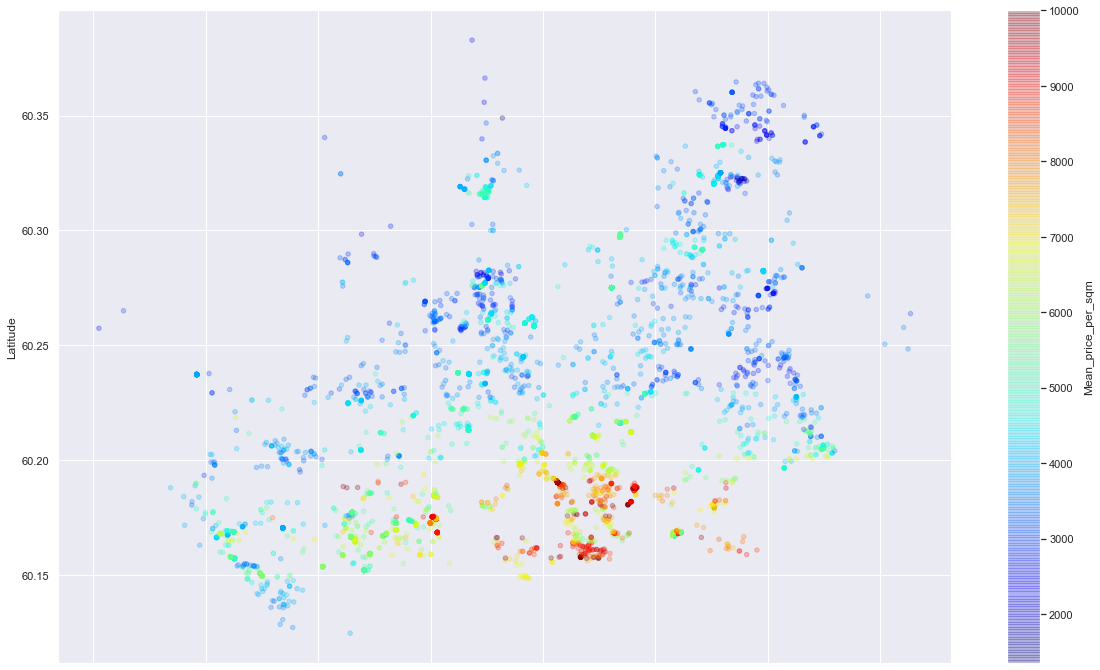

In [123]:
housing_subset_sorted.plot(kind="scatter", x="Longitude", y="Latitude", c="Mean_price_per_sqm", alpha=0.25,
             figsize=(20,12), vmax=10000, cmap=plt.get_cmap("jet"), colorbar=True)

In [110]:
housing_subset_sorted.tail(30)

Link  \
4554  https://www.etuovi.com/kohde/21229237?haku=M16...   
4555  https://www.etuovi.com/kohde/694572?haku=M1606...   
4556  https://www.etuovi.com/kohde/20630535?haku=M16...   
4557  https://www.etuovi.com/kohde/20244096?haku=M16...   
4558  https://www.etuovi.com/kohde/20304439?haku=M16...   
4559  https://www.etuovi.com/kohde/2233211?haku=M160...   
4560  https://www.etuovi.com/kohde/7974683?haku=M160...   
4561  https://www.etuovi.com/kohde/n96242?haku=M1606...   
4562  https://www.etuovi.com/kohde/7961447?haku=M160...   
4563  https://www.etuovi.com/kohde/21302337?haku=M16...   
4564  https://www.etuovi.com/kohde/7968480?haku=M160...   
4565  https://www.etuovi.com/kohde/7968482?haku=M160...   
4566  https://www.etuovi.com/kohde/7968478?haku=M160...   
4567  https://www.etuovi.com/kohde/7968481?haku=M160...   
4568  https://www.etuovi.com/kohde/7967547?haku=M160...   
4569  https://www.etuovi.com/kohde/7966255?haku=M160...   
4570  https://www.etuovi.com/kohde/7966551?haku=M160...   
4571  https://www.etuovi.com/kohde/21295048?haku=M16...   
4572  https://www.etuovi.com/kohde/20773504?haku=M16...   
4573  https://www.etuovi.com/kohde/20748704?haku=M16...   
4574  https://www.etuovi.com/kohde/1291225?haku=M160...   
4575  https://www.etuovi.com/kohde/20428848?haku=M16...   
4576  https://www.etuovi.com/kohde/20354867?haku=M16...   
4577  https://www.etuovi.com/kohde/21030452?haku=M16...   
4578  https://www.etuovi.com/kohde/7928830?haku=M160...   
4579  https://www.etuovi.com/kohde/q47733?haku=M1606...   
4580  https://www.etuovi.com/kohde/20591949?haku=M16...   
4581  https://www.etuovi.com/kohde/20200231?haku=M16...   
4582  https://www.etuovi.com/kohde/1291711?haku=M160...   
4583  https://www.etuovi.com/kohde/20731316?haku=M16...   

                                          Address   Price   Size  Year  \
4554              Korppitie 24, Vierumäki, Vantaa  110000   33.0  1973   
4555                Korppitie 24 A, Korso, Vantaa  215000   83.0  1974   
4556           Pirttirannantie 9, Seutula, Vantaa  139000   64.0  1966   
4557                Allitie 14, Vierumäki, Vantaa  185000   87.0  1965   
4558              Oravakuja 2, Leppäkorpi, Vantaa  225000   77.0  1990   
4559         Leppäkorventie 4, Leppäkorpi, Vantaa  159000   61.0  2013   
4560             Hallinpiha 5, Leppäkorpi, Vantaa  329000   93.0  2008   
4561  Oravakuja 6 E 20, Leppäkorpi,, Korso Vantaa  205000   71.0  1990   
4562        Leppäkorventie 18, Leppäkorpi, Vantaa  279000  106.1  1986   
4563       Leppäkorventie 20a, Leppäkorpi, Vantaa  194000   59.5  1988   
4564                 Tavitie 21 C2, Korso, Vantaa  370000  104.0  2020   
4565                 Tavitie 21 D2, Korso, Vantaa  370000  104.0  2020   
4566                 Tavitie 21 C1, Korso, Vantaa  370000  104.0  2020   
4567                 Tavitie 21 D1, Korso, Vantaa  370000  104.0  2020   
4568                 Tavitie 21 B1, Korso, Vantaa  370000  104.0  2020   
4569                 Tavitie 21 A1, Korso, Vantaa  370000  104.0  2020   
4570                 Tavitie 21 A2, Korso, Vantaa  370000  104.0  2020   
4571              Repolantie 2, Vierumäki, Vantaa  239000  123.0  1989   
4572               Hirvitie 5, Leppäkorpi, Vantaa  169000   55.0  1987   
4573               Hirvitie 9, Leppäkorpi, Vantaa  142000   38.0  1991   
4574             Kontiotie 26, Leppäkorpi, Vantaa  245000  100.5  1988   
4575            Kontiotie 24a, Leppäkorpi, Vantaa  219000   88.0  1974   
4576              Hirvitie 11, Leppäkorpi, Vantaa  210000   55.0  2016   
4577             Kärppäkuja 6, Leppäkorpi, Vantaa  195000  120.0  1959   
4578        Repolaisentie 7 E, Leppäkorpi, Vantaa  224000   72.0  1990   
4579             Hukantie 9 k, Leppäkorpi, Vantaa  228000   76.0  1991   
4580            Pesäpuunkuja 3, Vallinoja, Vantaa  206000   91.5  1997   
4581      Männiköntie 4, Riipilä/Männikkö, Vantaa  259000  110.0  1966   
4582               Reunarinne 2A, Riipilä, Vantaa  419000  156.0  2012   
4

In [99]:
housing_subset_sorted.drop("Mean_price", inplace=True, axis=1)

In [87]:
temp_subset.head(10)

i   j      dist
0  0   1  2.854099
1  0  25  3.147644
2  0  11  3.171879
3  0   7  3.367917
4  0  13  3.391980
5  0  27  3.399314
6  0   3  3.399440
7  0   2  3.492924
8  0   8  3.524238
9  0   4  3.532408

In [83]:
housing_subset_sorted.iloc[temp_subset.j].Price.mean()

423450.0